In [ ]:
import glob
import logging
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from src.clustering import preproc_features
from src.config import ConfigManager
from src.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
    get_multi_dic_data,
)
from src.preprocessing import apply_dic_filters, spatial_subsample
from src.roi import PolygonROISelector

%matplotlib widget
az.style.use("arviz-darkgrid")

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [51]:
target_date = "2024-08-23"
camera_name = "PPCX_Tele"
output_dir = Path("output") / f"{camera_name}_PyMC"
base_name = f"{camera_name}_{target_date}_PyMC_GMM"

SUBSAMPLE_FACTOR = 2  # Take every n point
SUBSAMPLE_METHOD = "regular"  # or 'random', 'stratified'
PRIOR_STRENGTH = 0.4  # Between 0 and 1

output_dir.mkdir(parents=True, exist_ok=True)

# dic_ids = (629,)
# Get DIC analysis metadata
# dic_ids = get_dic_analysis_ids(
#     db_engine, reference_date=target_date, camera_name=camera_name
# )

# Get DIC analysis metadata
reference_start_date = "2024-08-23"
reference_end_date = "2024-08-28"
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
)

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

2025-09-09 17:25:39,280 - INFO - Found 6 DIC analyses matching criteria


In [52]:
dic_analyses


,dic_id,camera_name,master_timestamp,slave_timestamp,master_image_id,slave_image_id,dt_hours
0,629,PPCX_Tele,2024-08-22 11:47:34+00:00,2024-08-23 11:03:33+00:00,34932,34948,23
1,630,PPCX_Tele,2024-08-23 12:03:35+00:00,2024-08-24 12:03:35+00:00,34955,34959,24
2,631,PPCX_Tele,2024-08-22 11:47:34+00:00,2024-08-25 11:03:33+00:00,34932,34970,71
3,632,PPCX_Tele,2024-08-22 11:47:34+00:00,2024-08-26 11:03:34+00:00,34932,34984,95
4,633,PPCX_Tele,2024-08-22 11:47:34+00:00,2024-08-27 11:03:33+00:00,34932,34996,119
5,634,PPCX_Tele,2024-08-22 11:47:34+00:00,2024-08-28 11:03:33+00:00,34932,35008,143


In [53]:
# Fetch DIC data
if len(dic_ids) == 0:
    raise ValueError("No DIC analyses found for the given criteria")
elif len(dic_ids) == 1:
    logging.info(f"Using DIC ID: {dic_ids[0]}")
    df = get_dic_data(dic_ids[0])
    df = apply_dic_filters(
        df,
        filter_outliers=config.get("dic.filter_outliers"),
        tails_percentile=config.get("dic.tails_percentile"),
        min_velocity=config.get("dic.min_velocity"),
        apply_2d_median=config.get("dic.apply_2d_median"),
        median_window_size=config.get("dic.median_window_size"),
        median_threshold_factor=config.get("dic.median_threshold_factor"),
    )
else:
    out = get_multi_dic_data(dic_ids, stack_results=False)
    # Apply filter for each df in the dictionary and then stack them
    logging.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")
    df = pd.concat(
        [
            apply_dic_filters(
                df,
                filter_outliers=config.get("dic.filter_outliers"),
                tails_percentile=config.get("dic.tails_percentile"),
                min_velocity=config.get("dic.min_velocity"),
                apply_2d_median=config.get("dic.apply_2d_median"),
                median_window_size=config.get("dic.median_window_size"),
                median_threshold_factor=config.get("dic.median_threshold_factor"),
            )
            for df in out.values()
        ],
        ignore_index=True,
    )

# To interactively select a ROI:
# selector = PolygonROISelector(file_path=config.get("data.roi_path"))
# selector.draw_interactive(image=img)

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logging.info(f"Data shape after filtering: {df.shape}")


# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    logging.info(f"Data shape before subsampling: {df.shape}")
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logging.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===

# Get clustering parameters from config
variables_names = config.get("clustering.variables_names")
logging.info(f"Using features: {variables_names}")

# Preprocess features
df_features = preproc_features(df)
X = df_features[variables_names].values
n_features = X.shape[1]
ndata = X.shape[0]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
logging.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-09 17:25:39,925 - INFO - Fetched DIC data for id 629 with 5251 points
2025-09-09 17:25:40,012 - INFO - Fetched DIC data for id 631 with 5251 points
2025-09-09 17:25:40,152 - INFO - Fetched DIC data for id 632 with 5251 points
2025-09-09 17:25:40,220 - INFO - Fetched DIC data for id 633 with 5251 points
2025-09-09 17:25:40,296 - INFO - Fetched DIC data for id 634 with 5251 points
2025-09-09 17:25:40,387 - INFO - Fetched DIC data for id 630 with 5251 points
2025-09-09 17:25:40,388 - INFO - Found stack of 6 DIC dataframes. Run filtering...
2025-09-09 17:25:40,388 - INFO - Starting DIC filtering pipeline with 5251 points
2025-09-09 17:25:40,393 - INFO - Percentile filtering: 5251 -> 5147 points (removed 104 outliers)
2025-09-09 17:25:40,394 - INFO - Min velocity filtering: 5147 -> 3835 points (removed 1312 points below 1)
2025-09-09 17:25:40,395 - INFO - Applying 2D median filter: window_size=5, threshold_factor=3.0
2025-09-09 17:25:40,402 - INFO - Estimated grid spacing: 64.00
202

Filtered 20994 points to 11233 points inside polygon
Subsampled from 11233 to 5617 points (50.0%)


2025-09-09 17:25:42,659 - INFO - Found 4 sector polygons for priors
2025-09-09 17:25:42,661 - INFO - Sector 0: 617 points with strong prior
2025-09-09 17:25:42,662 - INFO - Sector 1: 1074 points with strong prior
2025-09-09 17:25:42,665 - INFO - Sector 2: 1124 points with strong prior
2025-09-09 17:25:42,667 - INFO - Sector 3: 2488 points with strong prior


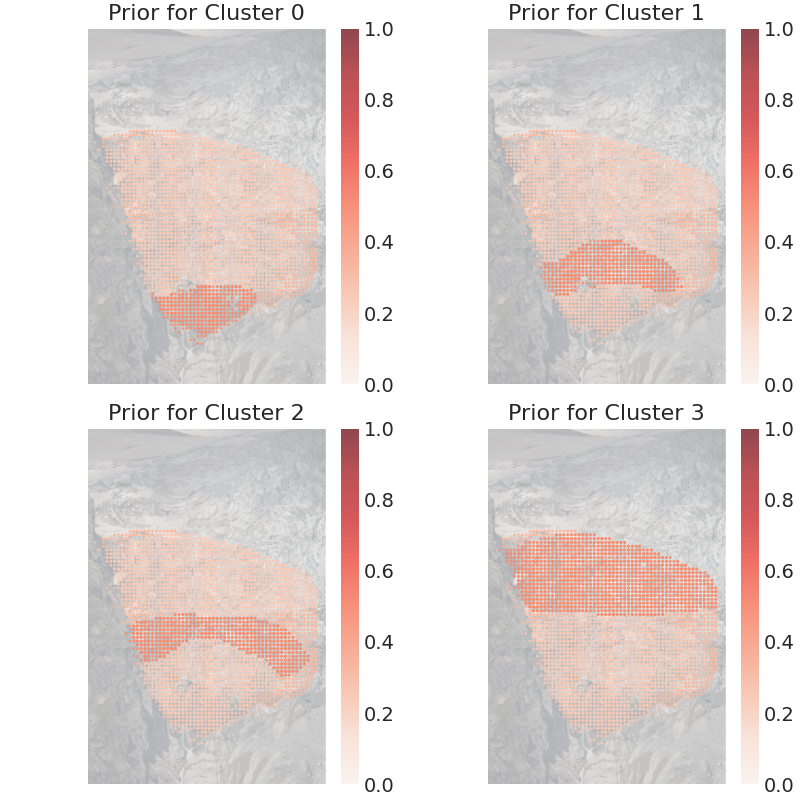

In [54]:
# === SPATIAL PRIOR SETUP ===
def assign_spatial_priors_dic(df, selectors, prior_strength=0.8):
    """Assign spatial prior probabilities based on polygon sectors."""
    ndata = len(df)
    k = len(selectors)
    prior_probs = np.ones((ndata, k)) / k  # default uniform

    for idx, selector in enumerate(selectors):
        mask = selector.contains_points(df["x"].values, df["y"].values)
        # Strong prior for points inside polygon
        prior_probs[mask] = (1 - prior_strength) / (
            k - 1
        )  # small prob for other clusters
        prior_probs[mask, idx] = prior_strength  # high prob for this cluster
        logging.info(f"Sector {idx}: {mask.sum()} points with strong prior")

    return prior_probs


# Load sector polygons for priors
sector_files = sorted(glob.glob("data/sectors_prior/*.json"))
sector_selectors = [PolygonROISelector.from_file(f) for f in sector_files]
k = len(sector_selectors)  # number of clusters = number of sectors
logging.info(f"Found {k} sector polygons for priors")

# Assign priors
prior_probs = assign_spatial_priors_dic(
    df, sector_selectors, prior_strength=PRIOR_STRENGTH
)

# Visualize priors
nrows = int(np.ceil(np.sqrt(k)))
ncols = int(np.ceil(k / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = [axes] if k == 1 else axes.flatten()
for cluster in range(k):
    axes[cluster].imshow(img, alpha=0.3)
    scatter = axes[cluster].scatter(
        df["x"],
        df["y"],
        c=prior_probs[:, cluster],
        cmap="Reds",
        s=1,
        alpha=0.7,
        vmin=0,
        vmax=1,
    )
    axes[cluster].set_title(f"Prior for Cluster {cluster}")
    axes[cluster].xaxis.set_ticks([])
    axes[cluster].yaxis.set_ticks([])
    plt.colorbar(scatter, ax=axes[cluster])

plt.show()

2025-09-09 17:25:50,961 - INFO - Model with spatial priors created


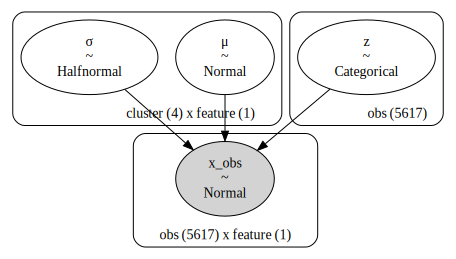

In [55]:
# === PYMC MODEL WITH SPATIAL PRIORS ===
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model_with_priors:
    # Cluster means (multivariate)
    μ = pm.Normal("μ", mu=0, sigma=3, dims=("cluster", "feature"))

    # Cluster standard deviations (diagonal covariance)
    σ = pm.HalfNormal("σ", sigma=1.5, dims=("cluster", "feature"))

    # Cluster assignments with spatial priors
    z = pm.Categorical("z", p=prior_probs, dims="obs")

    # Likelihood: each point comes from its assigned cluster
    pm.Normal("x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature"))

logging.info("Model with spatial priors created")
pm.model_to_graphviz(model_with_priors)

In [67]:
# # === SAMPLE FROM MODEL ===
# with model_with_priors:
#     logging.info("Starting MCMC sampling...")
#     idata_with_priors = pm.sample(
#         target_accept=0.9,
#         draws=1000,
#         tune=1000,
#         chains=5,
#         cores=5,
#         random_seed=RANDOM_SEED,
#     )

# logging.info("Sampling completed!")

# # --- SAVE OUTPUTS ---
# # save the posterior InferenceData object
# fpath = output_dir / f"{base_name}_pooled_posterior.idata.nc"
# az.to_netcdf(idata_with_priors, fpath)

# # Save the scaler with joblib
# joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")

In [ ]:
# # Check R-hat (should be < 1.01)
# logging.info(az.rhat(idata_with_priors))

# # Check effective sample size (should be > 100)
# logging.info(az.ess(idata_with_priors))

In [ ]:
# # Plot trace plots
# az.plot_trace(idata_with_priors, var_names=["μ", "σ"])

In [ ]:
# Get cluster assignments
idata = idata_with_priors
z_posterior = idata.posterior["z"]
z_samples = z_posterior.values.reshape(-1, z_posterior.shape[-1])

cluster_pred = np.zeros(z_posterior.shape[-1], dtype=int)
for i in range(z_posterior.shape[-1]):
    values, counts = np.unique(z_samples[:, i], return_counts=True)
    cluster_pred[i] = values[np.argmax(counts)]

# Get model parameters
mu_posterior = idata.posterior["μ"].mean(dim=["chain", "draw"]).values.flatten()
sigma_posterior = idata.posterior["σ"].mean(dim=["chain", "draw"]).values.flatten()


In [ ]:
# For 1D velocity clustering
from matplotlib.colors import Normalize
from scipy.stats import norm as scipy_norm


def plot_1d_velocity_clustering(df_features, idata, img, scaler=None):
    """Specialized plot for 1D velocity-only clustering."""

    # Get cluster assignments
    z_posterior = idata.posterior["z"]
    z_samples = z_posterior.values.reshape(-1, z_posterior.shape[-1])

    cluster_pred = np.zeros(z_posterior.shape[-1], dtype=int)
    for i in range(z_posterior.shape[-1]):
        values, counts = np.unique(z_samples[:, i], return_counts=True)
        cluster_pred[i] = values[np.argmax(counts)]

    # Get model parameters
    mu_posterior = idata.posterior["μ"].mean(dim=["chain", "draw"]).values.flatten()
    sigma_posterior = idata.posterior["σ"].mean(dim=["chain", "draw"]).values.flatten()

    # Distinct colors
    unique_labels = np.unique(cluster_pred)
    colors = ["#E31A1C", "#1F78B4", "#33A02C", "#FF7F00", "#6A3D9A"][
        : len(unique_labels)
    ]
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create figure with custom layout
    fig, axes = plt.subplots(2, 2, figsize=(8, 12))

    # Plot 1: Spatial clusters
    ax1 = axes[0, 0]
    ax1.set_title("Velocity-Based Spatial Clustering", fontsize=14, pad=10)

    if img is not None:
        ax1.imshow(img, alpha=0.3, cmap="gray")

    for label in unique_labels:
        mask = cluster_pred == label
        if np.any(mask):
            ax1.scatter(
                df_features.loc[mask, "x"],
                df_features.loc[mask, "y"],
                c=color_map[label],
                s=8,
                alpha=0.8,
                label=f"Velocity Cluster {label}",
                edgecolors="none",
            )
    ax1.legend(loc="upper right", framealpha=0.9, fontsize=10)
    ax1.set_aspect("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Velocity distribution
    ax3 = axes[0, 1]
    ax3.set_title("Velocity Distribution by Cluster", fontsize=14, pad=10)

    # Plot histograms for each cluster
    velocity = df_features["V"].values
    for label in unique_labels:
        mask = cluster_pred == label
        if np.any(mask):
            ax3.hist(
                velocity[mask],
                bins=35,
                alpha=0.7,
                density=True,
                color=color_map[label],
                label=f"Cluster {label}",
                edgecolor="white",
                linewidth=0.5,
            )

    # Overlay model distributions
    v_range = np.linspace(velocity.min(), velocity.max(), 200)
    for label in unique_labels:
        if scaler is not None:
            mu_orig = scaler.inverse_transform([[mu_posterior[label]]])[0, 0]
            sigma_orig = sigma_posterior[label] * scaler.scale_[0]
        else:
            mu_orig = mu_posterior[label]
            sigma_orig = sigma_posterior[label]

        model_dist = scipy_norm.pdf(v_range, mu_orig, sigma_orig)
        ax3.plot(
            v_range,
            model_dist,
            "--",
            color=color_map[label],
            linewidth=2.5,
            alpha=0.9,
            label=f"Model {label}",
        )
    ax3.set_xlabel("Velocity Magnitude", fontsize=12)
    ax3.set_ylabel("Density", fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10, framealpha=0.9)

    # Plot 3: Velocity field with quiver plot
    ax2 = axes[1, 0]
    ax2.set_title("Velocity Vector Field", fontsize=14, pad=10)

    if img is not None:
        ax2.imshow(img, alpha=0.7, cmap="gray")

    # Create quiver plot
    magnitudes = df_features["V"].to_numpy()
    vmin = 0.0
    vmax = np.max(magnitudes)
    norm = Normalize(vmin=vmin, vmax=vmax)
    q = ax2.quiver(
        df_features["x"].to_numpy(),
        df_features["y"].to_numpy(),
        df_features["u"].to_numpy(),
        df_features["v"].to_numpy(),
        magnitudes,
        scale=None,
        scale_units="xy",
        angles="xy",
        cmap="viridis",
        norm=norm,
        width=0.003,
        headwidth=2.5,
        alpha=1.0,
    )

    # Add colorbar
    cbar = fig.colorbar(q, ax=ax2, shrink=0.8, aspect=20, pad=0.02)
    cbar.set_label("Velocity Magnitude", rotation=270, labelpad=15)
    ax2.set_aspect("equal")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)

    # Plot 4: Statistics
    ax4 = axes[1, 1]
    ax4.axis("off")
    stats_text = "VELOCITY CLUSTERING STATISTICS\n" + "=" * 30 + "\n"
    for label in unique_labels:
        mask = cluster_pred == label
        count = mask.sum()

        if count == 0:
            continue

        v_mean = velocity[mask].mean()
        v_std = velocity[mask].std()
        v_median = np.median(velocity[mask])
        nmad = np.median(np.abs(velocity[mask] - v_median)) * 1.4826

        # Model parameters (in original scale)
        if scaler is not None:
            model_mu = scaler.inverse_transform([[mu_posterior[label]]])[0, 0]
            model_sigma = sigma_posterior[label] * scaler.scale_[0]
        else:
            model_mu = mu_posterior[label]
            model_sigma = sigma_posterior[label]

        stats_text += f"VELOCITY CLUSTER {label} (pts: {count})\n"
        stats_text += f"├─ Velocity: {v_mean:.4f} ± {v_std:.4f}\n"
        stats_text += f"├─ Median/NMAD: {v_median:.4f}/{nmad:.4f}\n"
        stats_text += f"├─ Model μ/σ: {model_mu:.4f}/{model_sigma:.4f}\n\n"

    ax4.text(
        0.05,
        0.95,
        stats_text,
        transform=ax4.transAxes,
        fontsize=8,
        verticalalignment="top",
        fontfamily="monospace",
        bbox=dict(
            boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8, edgecolor="navy"
        ),
    )

    return cluster_pred, fig


cluster_pred_1d, fig_1d = plot_1d_velocity_clustering(
    df_features, idata_with_priors, img, scaler
)
fig_1d.savefig(
    output_dir / f"{base_name}_velocity_only_results.png",
    dpi=300,
    bbox_inches="tight",
)

## CLASSIGY NEW DATA


In [68]:
# --- 2. LOAD POSTERIOR AND CLASSIFY NEW DATA ---
import numpy as np
from scipy.stats import norm

# Load posterior and scaler
idata_loaded = az.from_netcdf(output_dir / f"{base_name}_pooled_posterior.idata.nc")
scaler = joblib.load(output_dir / f"{base_name}_scaler.joblib")

In [83]:
# Get DIC data
date = "2024-08-23"
dic_ids = get_dic_analysis_ids(db_engine, camera_name=camera_name, reference_date=date)
if len(dic_ids) == 0:
    raise ValueError("No DIC analyses found for the given criteria")
elif len(dic_ids) > 1:
    logging.warning(
        "Multiple DIC analyses found for the given criteria. Using the first one."
    )
dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)
df_new = get_dic_data(dic_ids[0])

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df_new = selector.filter_dataframe(df_new, x_col="x", y_col="y")
logging.info(f"Data shape after filtering: {df_new.shape}")

2025-09-09 17:42:28,580 - INFO - Found 1 DIC analyses matching criteria
2025-09-09 17:42:29,109 - INFO - Data shape after filtering: (2353, 5)


Filtered 5251 points to 2353 points inside polygon


In [84]:
# Prepare new data
df_features_new = preproc_features(df_new)
X_new = df_features_new[variables_names].values
X_new_scaled = scaler.transform(X_new)
prior_probs_new = assign_spatial_priors_dic(
    df_new, sector_selectors, prior_strength=PRIOR_STRENGTH
)

2025-09-09 17:42:31,398 - INFO - Sector 0: 328 points with strong prior
2025-09-09 17:42:31,401 - INFO - Sector 1: 424 points with strong prior
2025-09-09 17:42:31,402 - INFO - Sector 2: 443 points with strong prior
2025-09-09 17:42:31,403 - INFO - Sector 3: 964 points with strong prior


In [85]:
# Extract posterior samples
mu_samples = idata_loaded.posterior["μ"].values  # (chains, draws, k, n_features)
sigma_samples = idata_loaded.posterior["σ"].values

mu_flat = mu_samples.reshape(
    -1, mu_samples.shape[-2], mu_samples.shape[-1]
)  # (n_samples, k, n_features)
sigma_flat = sigma_samples.reshape(-1, sigma_samples.shape[-2], sigma_samples.shape[-1])

n_samples = mu_flat.shape[0]
n_new = X_new_scaled.shape[0]
k = mu_flat.shape[1]

In [87]:
# Compute assignment probabilities
log_resp = np.zeros((n_samples, n_new, k))
for s in range(n_samples):
    for kk in range(k):
        lp = norm.logpdf(X_new_scaled, loc=mu_flat[s, kk], scale=sigma_flat[s, kk])
        log_lik = lp.sum(axis=1)
        log_prior = np.log(prior_probs_new[:, kk] + 1e-12)
        log_resp[s, :, kk] = log_prior + log_lik

resp_samples = np.exp(log_resp - log_resp.max(axis=2, keepdims=True))
resp_samples /= resp_samples.sum(axis=2, keepdims=True)  # (n_samples, n_new, k)

# Average over posterior samples
posterior_probs = resp_samples.mean(axis=0)  # (n_new, k)
cluster_pred = posterior_probs.argmax(axis=1)

In [ ]:
def plot_nd_velocity_clustering(
    df_features, X_scaled, idata, prior_probs, img, variables_names, scaler=None
):
    """Improved DIC clustering results with comprehensive statistics."""

    # Get posterior cluster assignments
    z_posterior = idata.posterior["z"]
    z_samples = z_posterior.values
    z_flat = z_samples.reshape(-1, z_samples.shape[-1])

    cluster_pred = np.zeros(z_samples.shape[-1], dtype=int)
    for i in range(z_samples.shape[-1]):
        values, counts = np.unique(z_flat[:, i], return_counts=True)
        cluster_pred[i] = values[np.argmax(counts)]

    # Assignment probabilities
    z_probs = np.stack(
        [
            (z_posterior == k).mean(dim=["chain", "draw"]).values
            for k in range(len(sector_selectors))
        ],
        axis=1,
    )

    # Uncertainty (entropy)
    uncertainty = -np.sum(z_probs * np.log(z_probs + 1e-10), axis=1)

    # Get posterior means and std devs from model
    mu_posterior = idata.posterior["μ"].mean(dim=["chain", "draw"])
    sigma_posterior = idata.posterior["σ"].mean(dim=["chain", "draw"])

    # Create discriminative colors
    unique_labels = np.unique(cluster_pred)
    n_clusters = len(unique_labels)

    # Use distinct, colorblind-friendly colors
    colors = [
        "#E31A1C",
        "#1F78B4",
        "#33A02C",
        "#FF7F00",
        "#6A3D9A",
        "#B15928",
        "#A6CEE3",
        "#B2DF8A",
        "#FB9A99",
        "#FDBF6F",
    ][:n_clusters]
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create simplified 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Cluster assignments with image overlay
    ax1 = axes[0, 0]
    if img is not None:
        ax1.imshow(img, alpha=0.3, cmap="gray")

    for label in unique_labels:
        mask = cluster_pred == label
        if np.any(mask):
            ax1.scatter(
                df_features.loc[mask, "x"],
                df_features.loc[mask, "y"],
                c=color_map[label],
                s=4,
                alpha=0.8,
                label=f"Cluster {label}",
                edgecolors="none",
            )

    ax1.set_title("Cluster Assignments (Spatial)", fontsize=14, fontweight="bold")
    ax1.legend(loc="upper right", framealpha=0.9)
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Assignment uncertainty
    ax2 = axes[0, 1]
    if img is not None:
        ax2.imshow(img, alpha=0.3, cmap="gray")

    scatter = ax2.scatter(
        df_features["x"],
        df_features["y"],
        c=uncertainty,
        cmap="plasma",
        s=4,
        alpha=0.8,
        vmin=0,
        vmax=uncertainty.max(),
    )
    ax2.set_title("Assignment Uncertainty", fontsize=14, fontweight="bold")
    ax2.set_aspect("equal")
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    cbar = plt.colorbar(scatter, ax=ax2, shrink=0.8)
    cbar.set_label("Entropy", rotation=270, labelpad=20)

    # Plot 3: Feature space (if multidimensional)
    ax3 = axes[1, 0]
    if len(variables_names) > 1:
        if "V" in df_features.columns and "angle_rad" in df_features.columns:
            for label in unique_labels:
                mask = cluster_pred == label
                if np.any(mask):
                    ax3.scatter(
                        df_features.loc[mask, "V"],
                        df_features.loc[mask, "angle_rad"],
                        c=color_map[label],
                        s=20,
                        alpha=0.7,
                        label=f"Cluster {label}",
                        edgecolors="black",
                        linewidth=0.3,
                    )
            ax3.set_xlabel("Velocity Magnitude", fontweight="bold")
            ax3.set_ylabel("Flow Direction (rad)", fontweight="bold")
            ax3.set_title("Clusters in Feature Space", fontsize=14, fontweight="bold")
        else:
            feat1, feat2 = variables_names[0], variables_names[1]
            for label in unique_labels:
                mask = cluster_pred == label
                if np.any(mask):
                    ax3.scatter(
                        df_features.loc[mask, feat1],
                        df_features.loc[mask, feat2],
                        c=color_map[label],
                        s=20,
                        alpha=0.7,
                        label=f"Cluster {label}",
                        edgecolors="black",
                        linewidth=0.3,
                    )
            ax3.set_xlabel(feat1, fontweight="bold")
            ax3.set_ylabel(feat2, fontweight="bold")
            ax3.set_title(
                f"Clusters: {feat1} vs {feat2}", fontsize=14, fontweight="bold"
            )

        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        # For 1D case, show velocity distribution
        feat = variables_names[0]
        for label in unique_labels:
            mask = cluster_pred == label
            if np.any(mask):
                ax3.hist(
                    df_features.loc[mask, feat],
                    bins=30,
                    alpha=0.7,
                    color=color_map[label],
                    label=f"Cluster {label}",
                    density=True,
                )
        ax3.set_xlabel(feat, fontweight="bold")
        ax3.set_ylabel("Density", fontweight="bold")
        ax3.set_title(f"{feat} Distribution by Cluster", fontsize=14, fontweight="bold")
        ax3.grid(True, alpha=0.3)
        ax3.legend()

    # Plot 4: Comprehensive cluster statistics
    ax4 = axes[1, 1]
    ax4.axis("off")

    # Calculate detailed statistics
    stats_text = "CLUSTER STATISTICS\n" + "=" * 50 + "\n\n"

    for label in unique_labels:
        mask = cluster_pred == label
        count = mask.sum()

        if count == 0:
            continue

        # Spatial statistics
        x_mean = df_features.loc[mask, "x"].mean()
        y_mean = df_features.loc[mask, "y"].mean()
        x_std = df_features.loc[mask, "x"].std()
        y_std = df_features.loc[mask, "y"].std()

        # Feature statistics (original scale if scaler provided)
        feature_stats = {}
        for i, feat_name in enumerate(variables_names):
            if scaler is not None:
                # Transform back to original scale for interpretation
                feat_scaled = X_scaled[mask, i]
                feat_original = scaler.inverse_transform(
                    np.column_stack([X_scaled[mask, :]])
                )[:, i]
                feat_mean_orig = feat_original.mean()
                feat_std_orig = feat_original.std()
                feature_stats[feat_name] = (feat_mean_orig, feat_std_orig)
            else:
                feat_mean = df_features.loc[mask, feat_name].mean()
                feat_std = df_features.loc[mask, feat_name].std()
                feature_stats[feat_name] = (feat_mean, feat_std)

        # Model parameters (posterior means)
        model_mu = mu_posterior.values[label, :]
        model_sigma = sigma_posterior.values[label, :]

        # Uncertainty statistics
        avg_uncertainty = uncertainty[mask].mean()
        max_prob = z_probs[mask, label].mean()

        stats_text += f"CLUSTER {label} ({count} points)\n"
        stats_text += f"├─ Spatial Center: ({x_mean:.1f}, {y_mean:.1f})\n"
        stats_text += f"├─ Spatial Spread: (σx={x_std:.1f}, σy={y_std:.1f})\n"

        for feat_name, (mean_val, std_val) in feature_stats.items():
            if feat_name == "V":  # Velocity
                stats_text += f"├─ Velocity: {mean_val:.3f} ± {std_val:.3f}\n"
            elif feat_name == "angle_rad":  # Angle
                stats_text += f"├─ Direction: {mean_val:.2f} ± {std_val:.2f} rad\n"
            else:
                stats_text += f"├─ {feat_name}: {mean_val:.3f} ± {std_val:.3f}\n"

        stats_text += f"├─ Model μ: [{', '.join([f'{x:.2f}' for x in model_mu])}]\n"
        stats_text += f"├─ Model σ: [{', '.join([f'{x:.2f}' for x in model_sigma])}]\n"
        stats_text += f"├─ Avg Uncertainty: {avg_uncertainty:.3f}\n"
        stats_text += f"└─ Avg Probability: {max_prob:.3f}\n\n"

    ax4.text(
        0.05,
        0.95,
        stats_text,
        transform=ax4.transAxes,
        fontsize=10,
        verticalalignment="top",
        fontfamily="monospace",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
    )

    # plt.tight_layout()
    return cluster_pred, z_probs, uncertainty, fig


# Usage:
# For multidimensional clustering
cluster_pred, z_probs, uncertainty, fig = plot_nd_velocity_clustering(
    df_features, X_scaled, idata, prior_probs, img, variables_names, scaler
)
fig.savefig(
    output_dir / f"{base_name}_improved_results.png", dpi=300, bbox_inches="tight"
)
